100%|██████████| 1200/1200 [00:00<00:00, 1917.38it/s]


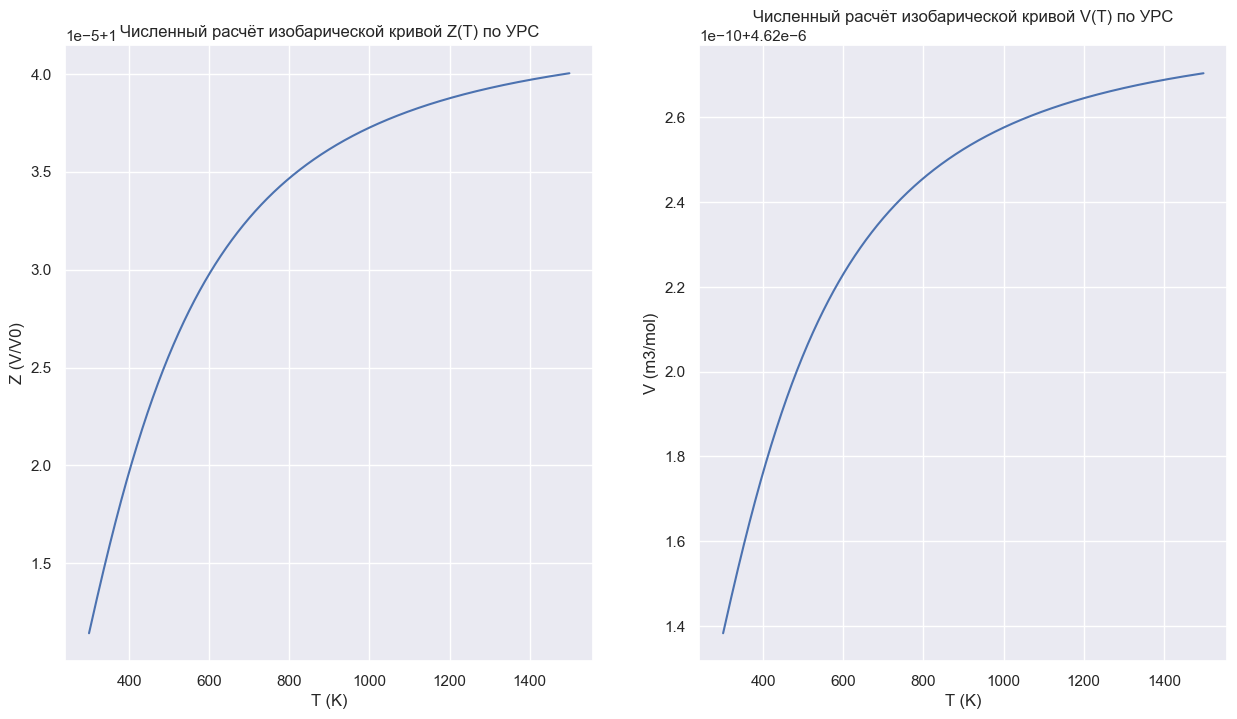

In [1]:
import numpy as np
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
teta = 1250 
R = 8.31
gamma = 1.67
K = 210 * 10**9
K_ = 2.23
molar_mass_B = 10.811e-3  # kg/mol
density_B = 2340  # kg/m³
V0 = molar_mass_B / density_B  # 4.62e-6 m³/mol

T_values = []
z_values = []
v_values = []

def calc_CvEinst(T):
    exp_term = math.exp(teta/T)
    return 3 * R * (teta/T)**2 * exp_term / (exp_term - 1)**2

def isoBarical(Z, T):
    eta = (Z)**(1/3)
    term1_exp_arg = 3/2 * (K_ - 1) * (1 - eta)
    exp_val = np.exp(term1_exp_arg)
    term1 = 3 * K * (1-eta)/(eta**2) * exp_val
    term2 = calc_CvEinst(T) * gamma / (Z * V0)
    return term1 + term2

def calculate_isobar(pressure):
    global T_values, z_values, v_values
    T_values = []
    z_values = []
    v_values = []

    for T in tqdm(range(300, 1500)):
        T_values.append(T)
        low_z, high_z = 0.6, 5
        
        for _ in range(100):
            mid_z = (low_z + high_z) / 2
            val_mid = isoBarical(mid_z, T)
            if val_mid > pressure:
                low_z = mid_z
            else: 
                high_z = mid_z
                
        z_values.append((low_z + high_z)/2)
    
    v_values = [z * V0 for z in z_values]
    
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, z_values)
    plt.title("Численный расчёт изобарической кривой Z(T) по УРС")
    plt.xlabel("T (K)"); plt.ylabel("Z (V/V0)"); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(T_values, v_values)
    plt.title("Численный расчёт изобарической кривой V(T) по УРС")
    plt.xlabel("T (K)"); plt.ylabel("V (m3/mol)"); plt.grid(True)
    plt.show()

calculate_isobar(101325)

Коэффициенты: b0=4.620e-06, b1=3.701e-13, b2=-3.969e-16, b3=1.497e-19
R²: 0.998


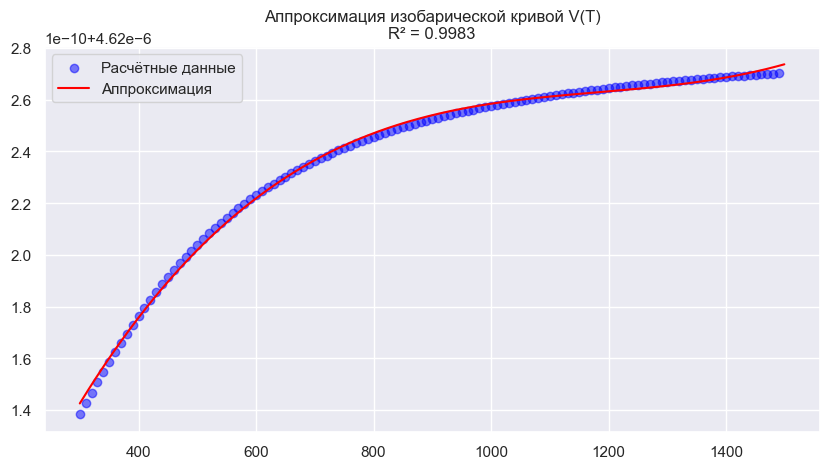

In [2]:
class CorrectedRegression:
    def __init__(self):
        self.coeffs = np.zeros(4)
        
    def fit(self, T, Z):
        T = np.asarray(T)
        V = np.array(v_values)
        Z = np.asarray(Z)
        X = T - 300  #центрирование
        
        X_mat = np.column_stack([X**0, X, X**2, X**3])
        self.coeffs = np.linalg.lstsq(X_mat, V, rcond=None)[0]
        
    def predict(self, T):
        X = np.asarray(T) - 300
        return self.coeffs[0] + self.coeffs[1]*X + self.coeffs[2]*X**2 + self.coeffs[3]*X**3
    
    def r_squared(self, T, V):
        Z_pred = self.predict(T)
        Z_mean = np.mean(V)
        ss_total = np.sum((V - Z_mean) ** 2)
        ss_res = np.sum((V - Z_pred) ** 2)
        return 1 - (ss_res / ss_total)
    
reg = CorrectedRegression()
reg.fit(T_values, v_values)
b0, b1, b2, b3 = reg.coeffs
r2 = reg.r_squared(T_values, v_values)
print(f"Коэффициенты: b0={b0:.3e}, b1={b1:.3e}, b2={b2:.3e}, b3={b3:.3e}")
print(f"R²: {reg.r_squared(T_values, v_values):.3f}")

plt.figure(figsize=(10, 5))
plt.scatter(T_values[::10], v_values[::10], label="Расчётные данные", color="blue", alpha=0.5)
plt.plot(T_values, reg.predict(T_values), label='Аппроксимация', color="red")
plt.title(f"Аппроксимация изобарической кривой V(T)\nR² = {r2:.4f}")
plt.legend()
plt.grid(True)
plt.show()

Финальные коэффициенты:
c0 = 4.620e-06 m^3/mol
c1 = 3.701e-13 m^3/(mol·K)
c2 = -3.969e-16 m^3/(mol·K^2)
c3 = 1.497e-19 m^3/(mol·K^3)

--- Проверка значений V и dV/dT из аппроксимации ---
При T = 300 K (X = 0 K):
  V_approx   = 4.6201e-06 m^3/mol
  V_original = 4.6201e-06 m^3/mol (из calculate_isobar)
  dV/dT_approx = 3.7012e-13 m^3/(mol·K)
  Alpha_check  = 2.6704e-08 K^-1 (или 0.0267 * 10^-6 K^-1)
При T = 500 K (X = 200 K):
  V_approx   = 4.6202e-06 m^3/mol
  V_original = 4.6202e-06 m^3/mol (из calculate_isobar)
  dV/dT_approx = 2.2934e-13 m^3/(mol·K)
  Alpha_check  = 1.6546e-08 K^-1 (или 0.0165 * 10^-6 K^-1)
При T = 1000 K (X = 700 K):
  V_approx   = 4.6203e-06 m^3/mol
  V_original = 4.6203e-06 m^3/mol (из calculate_isobar)
  dV/dT_approx = 3.4506e-14 m^3/(mol·K)
  Alpha_check  = 2.4895e-09 K^-1 (или 0.0025 * 10^-6 K^-1)
При T = 1500 K (X = 1200 K):
  V_approx   = 4.6203e-06 m^3/mol
  dV/dT_approx = 6.4159e-14 m^3/(mol·K)
  Alpha_check  = 4.6288e-09 K^-1 (или 0.0046 * 10^-6 K^-1)
----

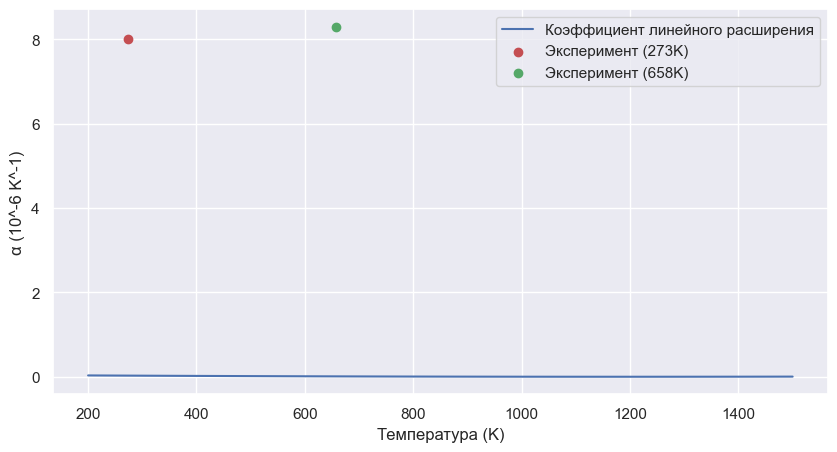

In [3]:
"""
#преобразование коэффициентов
V0 = molar_mass_B / density_B
c0 = V0 * b0
c1 = V0 * b1
c2 = V0 * b2 
c3 = V0 * b3"""


#преобразование коэффициентов
V0 = molar_mass_B / density_B
c0 = b0
c1 = b1
c2 = b2 
c3 = b3
print(f"Финальные коэффициенты:")
print(f"c0 = {c0:.3e} m^3/mol")
print(f"c1 = {c1:.3e} m^3/(mol·K)")
print(f"c2 = {c2:.3e} m^3/(mol·K^2)")
print(f"c3 = {c3:.3e} m^3/(mol·K^3)")

print("\n--- Проверка значений V и dV/dT из аппроксимации ---")
test_temps_for_deriv = [300, 500, 1000, 1500]
for temp_k in test_temps_for_deriv:
    X_val = temp_k - 300
    # Используем b0, b1, b2, b3 (которые вы присвоили в c0, c1, c2, c3)
    V_approx = b0 + b1*X_val + b2*X_val**2 + b3*X_val**3
    dVdT_approx = b1 + 2*b2*X_val + 3*b3*X_val**2
    alpha_val_check = (dVdT_approx / V_approx) / 3 if V_approx != 0 else float('nan')
    print(f"При T = {temp_k} K (X = {X_val} K):")
    print(f"  V_approx   = {V_approx:.4e} m^3/mol")
    # Сравним с v_values, если они доступны и T_values тоже
    if 'T_values' in globals() and 'v_values' in globals() and temp_k in T_values:
        idx = T_values.index(temp_k)
        print(f"  V_original = {v_values[idx]:.4e} m^3/mol (из calculate_isobar)")
    print(f"  dV/dT_approx = {dVdT_approx:.4e} m^3/(mol·K)")
    print(f"  Alpha_check  = {alpha_val_check:.4e} K^-1 (или {alpha_val_check*1e6:.4f} * 10^-6 K^-1)")
print("-----------------------------------------------------\n")

def alpha_linear(T):
    X = T - 300
    V = c0 + c1*X + c2*X**2 + c3*X**3
    #V = c0 + c1*T + c2*T**2 + c3*T**3
    #dVdT = c1 + 2*c2*T + 3*c3*T**2
    dVdT = c1 + 2*c2*X + 3*c3*X**2 
    return (dVdT/V)/3

T_test = [273, 658]
for T in T_test:
    print(f"α({T}K) = {alpha_linear(T):.3e} K^-1")


T_range = np.linspace(200, 1500, 100)
alpha = [alpha_linear(T)*1e6 for T in T_range]  #10^-6 K^-1

plt.figure(figsize=(10, 5))
plt.plot(T_range, alpha, label='Коэффициент линейного расширения')
plt.xlabel("Температура (K)"); plt.ylabel("α (10^-6 K^-1)")
plt.scatter(273, 8, color='r', label='Эксперимент (273K)')
plt.scatter(658, 8.3, color='g', label='Эксперимент (658K)')
plt.legend()
plt.grid(True)
plt.show()

#Расчёт Cantera (учесть центрирование!)